## 문서 벡터를 이용한 추천 시스템(Recommendation System using Document Embedding)

### 1. 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [63]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.model_selection import train_test_split
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
  from tensorflow.keras.models import load_model
  from sklearn.metrics.pairwise import cosine_similarity
  import nltk
  from nltk.corpus import stopwords
  from nltk.stem import WordNetLemmatizer
  import re
  from nltk.tokenize import word_tokenize, sent_tokenize

In [68]:
def sentence_preprocessing(user_setence, label):
  '''데이터 로드'''
  df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/word embedding_hyun/data/dataset_210626_215600.csv')
  df.drop('Unnamed: 0', axis=1, inplace=True)

  '''사용자 입력 문장 전처리'''
  user_setence = user_setence.replace("[^a-zA-Z]", " ")
  # 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
  user_setence = ' '.join([w for w in user_setence.split() if len(w)>3])
  # 전체 단어에 대한 소문자 변환
  user_setence = user_setence.lower()
  nltk.download('stopwords')
  # NLTK로부터 불용어 로드
  stop_words = stopwords.words('english') 
  tokenized_doc = user_setence.split() # 토큰화
  tokenized_doc = [item for item in tokenized_doc if item not in stop_words] # 불용어 제거
  nltk.download('wordnet')
  n = WordNetLemmatizer()
  tokenized_doc = [n.lemmatize(item) for item in tokenized_doc] # 표제어 추출

  '''같은 라벨의 데이터에 사용자 문장 추가'''
  same_label_df = df[df['label']==label]
  sent_text = same_label_df['lemmatizated']
  # 원본 데이터의 str부분을 전처리
  nltk.download('punkt')
  normalized_text = []
  for string in sent_text:
      tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
      normalized_text.append(tokens)
  # 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
  result = []
  result = [word_tokenize(sentence) for sentence in normalized_text]
  result.append(tokenized_doc)

  return same_label_df, result

### 2. 사전 훈련된 워드 임베딩 로드하여 단어 벡터 평균 계산

In [161]:
# 단어 벡터 평균 구하기
def vectors(model_path, document_list):
    # 모델 로드
    from gensim.models import Word2Vec, KeyedVectors
    word2vec_model = KeyedVectors.load_word2vec_format(model_path)

    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]
        
        if doc2vec is None:
            doc2vec = np.empty(100,)
            doc2vec[:] = 0
            document_embedding_list.append(doc2vec)
        else:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

### 3. 문서 간 유사도 계산

향수 데이터에서는 전체 문서간의 코사인 유사도 매트릭스가 아닌 같은 라벨 내에서 사용자 입력문장과의 유사도 매트릭스를 구해야 함

In [112]:
def recommendations(df, document_embedding_list):
    cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)

    perfumes = df[['name', 'review']]

    # 전체 cosine유사도 행렬에서 사용자 입력 문장과 가장 유사한 순으로 리뷰 정렬
    sim_scores = list(enumerate(cosine_similarities[-1]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:100]

    # 가장 유사한 리뷰 10개의 인덱스
    per_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = df.iloc[per_indices].reset_index(drop=True)

    top3_df = pd.DataFrame(columns=['name','similarity','review'])

    # 데이터프레임으로부터 순차적으로 출력
    recommend_perfume = []
    for index, row in recommend.iterrows():
      if len(recommend_perfume)==3:
        break
      if row['name'] in recommend_perfume:
        continue
      else:
        recommend_perfume.append(row['name'])
        top3_df = top3_df.append({'name':row['name'], 'similarity':sim_scores[index][1], 'review':row['review']},ignore_index=True)
      print('Top {}'.format(len(recommend_perfume)))
      print('향수 명: ' ,row['name'])
      print('유사도: ',sim_scores[index][1])
      print('리뷰: ', row['review'])
      print()
      print()
    
    return top3_df

전체 실행

In [113]:
model_path = '/content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/word embedding_hyun/model/w2v_10window'
user_sentence = 'I am sitting on the beach with a cool breeze I am surrounded by coconut palm water and I sip a refreshing grapefruit sparkling drink'
label = 0
same_label_df, result = sentence_preprocessing(user_sentence, label)
document_embedding_list = vectors(model_path, result)
top3_df = recommendations(same_label_df, document_embedding_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Top 1
향수 명:  Light Blue Dolce&Gabbana for women
유사도:  0.9269124360695515
리뷰:  This D&G is reminiscent of a golden beach in summer. Lemon and lime decorating my pina colada glass and I can smell their charm as I dip my lips into that glass of tropical heaven; the sun melting fruit juice onto my mocha-tan face. 
There's a citrus zing floating mysteriously through the air as I lay and stare contently at the sky that is a blue of sorts. Light blue though, is the breeze beneath it, convincing you all to buy a bottle of such sweetness.


Top 2
향수 명:  Un Jardin Sur Le Nil Hermès for women and men
유사도:  0.9180963901992103
리뷰:  The boat along the green waters of the Nile delta, or any delta. The light splash of an aquatic creature. The sun reflected into the crystaline waves and bloom of the nufars. All the luxury of the water and its lush offspring in a scent that retains the so called "aquatic notes" in an authentic and unfading way, like none other perfume can do. 
Un Jardin sur le Nile is t

In [114]:
top3_df

,name,similarity,review
0,Light Blue Dolce&Gabbana for women,0.926912,This D&G is reminiscent of a golden beach in s...
1,Un Jardin Sur Le Nil Hermès for women and men,0.918096,The boat along the green waters of the Nile de...
2,Wood Sage & Sea Salt Jo Malone London for wome...,0.906803,This perfume smells like the East Coast Surfin...


In [73]:
model_path = '/content/gdrive/MyDrive/Colab Notebooks/deeplearning_NLP/perfume/word embedding_hyun/model/w2v_10window'
user_sentence = 'He smells like a light cigarette with the sweet liquor he drank last night Very manly strong voice as sweet as honey and comfortable and warm in his arms'
label = 1
same_label_df, result = sentence_preprocessing(user_sentence, label)
document_embedding_list = vectors(model_path, result)
recommendations(same_label_df, document_embedding_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Top 1
향수 명:  Tobacco Vanille Tom Ford for women and men
유사도:  0.9547883859819074
리뷰:  I tried this yesterday, and it started out lovely! Fruity tobaccoleaves, sweet dried fruits and warm vanilla. BUT then! Something just morphs right infront of my eyes. I try to cling on to the memory of the lovely tobacco and warm vanilla but everything is just... Beeswax. Beeswax and propolis. NO! No this is not at all what I wanted. I wanted to smell like a mysterious and interesting person with cognac in one hand and pipe tobacco in the other. 
Now I smell like a dusty old candle. Oh gods why. 
(I love honey, but I rarely can stand the smell of beeswax. It just reminds me of a heavy cold and thick pomades for cracked lips. And pungent smelling candles.) 
NO, this breaks my heart. 
I need to try it again, when the weather gets colder. This can't be true.


Top 2
향수 명:  L’Homme Ideal Eau de Parfum Guerlain for men
유사도:  0.9532000753869144
리뷰:  I just received this today and I’m totally obsessed with 

In [78]:
result[-1]

['sitting',
 'beach',
 'cool',
 'breeze',
 'surrounded',
 'coconut',
 'palm',
 'water',
 'refreshing',
 'grapefruit',
 'sparkling',
 'drink']

In [127]:
from collections import OrderedDict
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Return top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        dic = dict()
        for i, (key, value) in enumerate(node_weight.items()):
            dic[key]=value
            if i > number:
                break
        return dic
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

In [160]:
tr4w = TextRank4Keyword()

# 사용자 입력 문장의 키워드 추출
user_keyword = []
tr4w.analyze(user_sentence, candidate_pos = ['NOUN', 'PROPN', 'ADJ', 'ADV'], window_size=5, lower=False)
user_keyword = list(tr4w.get_keywords(100).keys())
user_keyword = [word for word in user_keyword if word in word2vec_model.vocab] # 임베딩 벡터에 없는 단어는 제외
user_keyword

['palm',
 'coconut',
 'water',
 'breeze',
 'grapefruit',
 'cool',
 'sparkling',
 'beach',
 'drink']

In [207]:
# 추천 향수 리뷰의 키워드 추출하여 dataframe에 cloumn으로 저장
top3_keyword = []
for i in range(0,len(top3_df)):
  tr4w.analyze(top3_df['review'][i], candidate_pos = ['NOUN', 'PROPN', 'ADJ'], window_size=5, lower=False)
  keywords = list(tr4w.get_keywords(100).keys())
  keywords = [word for word in keywords if word in word2vec_model.vocab] # 임베딩 벡터에 없는 단어는 제외
  top3_keyword.append(keywords)

top3_df['keywords']=top3_keyword

In [208]:
top3_df

,name,similarity,review,keywords
0,Light Blue Dolce&Gabbana for women,0.926912,This D&G is reminiscent of a golden beach in s...,"[blue, glass, fruit, juice, mocha, tan, remini..."
1,Un Jardin Sur Le Nil Hermès for women and men,0.918096,The boat along the green waters of the Nile de...,"[aquatic, water, green, scent, pool, turquoise..."
2,Wood Sage & Sea Salt Jo Malone London for wome...,0.906803,This perfume smells like the East Coast Surfin...,"[sun, salt, hint, breeze, faintest, sea, tan, ..."


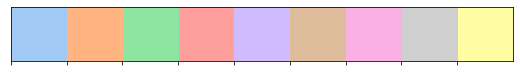

In [209]:
import seaborn as sns
custom_palette = sns.color_palette("pastel", len(user_keyword))
sns.palplot(custom_palette)

In [210]:
# user keyword에 랜덤 파스텔 컬러 할당
user_dict = {word : custom_palette[i] for i,word in enumerate(user_keyword)}
user_dict

{'beach': (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 'breeze': (1.0, 0.6235294117647059, 0.6078431372549019),
 'coconut': (1.0, 0.7058823529411765, 0.5098039215686274),
 'cool': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 'drink': (1.0, 0.996078431372549, 0.6392156862745098),
 'grapefruit': (0.8156862745098039, 0.7333333333333333, 1.0),
 'palm': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 'sparkling': (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 'water': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)}

In [238]:
color_list = []
for i in range(0, len(top3_df)):
  top3_dict = dict.fromkeys(top3_df['keywords'][i])
  index = 0
  for uw in user_dict.keys():
    for tw in top3_dict.keys():
      # 초기 임계값 0.5로 잡아봄
      if word2vec_model.similarity(uw, tw) > 0.5:
        # 컬러 할당이 안되어있는 상태라면 처음 값 넣어줌
        if top3_dict[tw] is None:
          top3_dict[tw] = list(user_dict.items())[index]
        # 컬러 할당이 되어있는 상태라면 유사도 더 높은 컬러로 넣어줌
        elif word2vec_model.similarity(uw, tw) > word2vec_model.similarity(top3_dict[tw][0], tw): #이전 user word와 비교
          top3_dict[tw] = list(user_dict.items())[index]
    index+=1
  color_list.append(top3_dict)

# 데이터 프레임에 색상 정보 추가
top3_df['colors']=color_list

In [240]:
top3_df

,name,similarity,review,keywords,colors
0,Light Blue Dolce&Gabbana for women,0.926912,This D&G is reminiscent of a golden beach in s...,"[blue, glass, fruit, juice, mocha, tan, remini...","{'blue': ('cool', (0.8705882352941177, 0.73333..."
1,Un Jardin Sur Le Nil Hermès for women and men,0.918096,The boat along the green waters of the Nile de...,"[aquatic, water, green, scent, pool, turquoise...","{'aquatic': ('cool', (0.8705882352941177, 0.73..."
2,Wood Sage & Sea Salt Jo Malone London for wome...,0.906803,This perfume smells like the East Coast Surfin...,"[sun, salt, hint, breeze, faintest, sea, tan, ...","{'sun': ('beach', (0.8117647058823529, 0.81176..."
